In [46]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

!pip install qiskit ipywidgets

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from collections import Counter
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# import basic plot tools
from qiskit.visualization import plot_histogram

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
qc = QuantumCircuit(3)
qc.cz(0, 2)
qc.cz(1, 2)
oracle_ex3 = qc.to_gate()
oracle_ex3.name = "U$_\omega$"

In [36]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)
    for qubit in range(nqubits-1):
       qc.cz(qubit, qubit+1)
    for qubit in range(nqubits):
        qc.h(qubit)
        qc.z(qubit)
    for qubit in range(nqubits-1):
       qc.cz(qubit, qubit+1)
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [34]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

In [37]:
n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw()

┌───┐┌─────────────┐┌────────┐ ░ ┌─┐      
   q_0: ┤ H ├┤0            ├┤0       ├─░─┤M├──────
        ├───┤│             ││        │ ░ └╥┘┌─┐   
   q_1: ┤ H ├┤1 U$_\omega$ ├┤1 U$_s$ ├─░──╫─┤M├───
        ├───┤│             ││        │ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├┤2            ├┤2       ├─░──╫──╫─┤M├
        └───┘└─────────────┘└────────┘ ░  ║  ║ └╥┘
meas: 3/══════════════════════════════════╩══╩══╩═
                                          0  1  2

In [50]:
def ourStates():
    aer_sim = Aer.get_backend('aer_simulator')
    transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
    qobj = assemble(transpiled_grover_circuit)
    results = aer_sim.run(qobj).result()
    counts = results.get_counts()
    plot_histogram(counts)
    counts_list = list(counts)
    return counts_list
print(ourStates())

['111', '011', '000', '100']


In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


def categorical_to_numpy(labels_in):
  labels = []
  for label in labels_in:
    if label == 'dog':
      labels.append(np.array([1, 0]))
    else:
      labels.append(np.array([0, 1]))
  return np.array(labels)


def load_data():
  # Run this cell to download our data into a file called 'cifar_data'
  !wget -O cifar_data https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%204%20_%205%20-%20Neural%20Networks%20_%20CNN/dogs_v_roads

  # now load the data from our cloud computer
  import pickle
  data_dict = pickle.load(open( "cifar_data", "rb" ));
  
  data   = data_dict['data']
  labels = data_dict['labels']
  
  return data, labels

In [40]:
data, labels = load_data()

--2023-02-25 17:14:14--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%204%20_%205%20-%20Neural%20Networks%20_%20CNN/dogs_v_roads
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.97.128, 173.194.214.128, 142.251.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3689015 (3.5M) [application/octet-stream]
Saving to: ‘cifar_data’

cifar_data          100%[===================>]   3.52M  --.-KB/s    in 0.02s   

2023-02-25 17:14:14 (191 MB/s) - ‘cifar_data’ saved [3689015/3689015]



In [53]:
possible_k = [1, 3, 5, 7, 10, 15, 17, 20]
bit_list = ["000", "001", "010", "011", "100", "101", "110", "111"]
state_list = ourStates()
state_one = state_list[0]
#state_two = state_list[1]
index = bit_list.index(state_one)
k = possible_k[index]
print(k)
#X_train, X_test, y_train, y_test = model_selection.train_test_split(data, labels, test_size=0.2, random_state=1)
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, labels, test_size=0.2)

knn_model = KNeighborsClassifier(n_neighbors = k) # Change this!
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

1
0.8416666666666667


In [54]:
def plot_one_image(data, labels, img_idx):
  from google.colab.patches import cv2_imshow
  import cv2
  import matplotlib.pyplot as plt
  my_img   = data[img_idx, :].squeeze().reshape([32,32,3]).copy()
  my_label = labels[img_idx]
  print('label: %s'%my_label)
  fig, ax = plt.subplots(1,1)

  img = ax.imshow(my_img, extent=[-1,1,-1,1])

  x_label_list = [0, 8, 16, 24, 32]
  y_label_list = [0, 8, 16, 24, 32]

  ax.set_xticks([-1, -0.5, 0, 0.5, 1])
  ax.set_yticks([-1, -0.5, 0, 0.5, 1])

  ax.set_xticklabels(x_label_list)
  ax.set_yticklabels(y_label_list)

  fig.show(img)

label: road
prediction: road


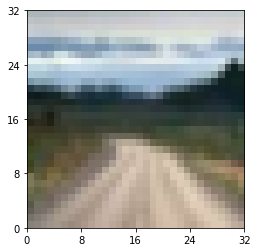

In [55]:
# Specify which image you want to show
image_id = 40 #Change this!

# Visualize the image
plot_one_image(X_test, y_test, image_id)

# Use the model to predict what this might be and print it
print('prediction:', knn_model.predict([X_test[image_id]])[0])